In [5]:
import pandas as pd
from matplotlib import pyplot as plt
from fit import helpers, gee, dproc, plotter
import numpy as np
import matplotlib
from IPython.display import Markdown as md, display
matplotlib.rcParams.update({'font.size': 17})

# Read data

In [6]:
df=pd.read_csv('./data/presernovi/2023_06_28.csv')
df_results=pd.DataFrame()

# Analiza
Za klasifikacijo ritmičnosti uporabimo enokomponento metodo cosinor.
Za analizo ritmičnosti testiramo 3 metodologije:
- enokomponenti cosinor in povprečenje individualnih modelov
- enokomponentni cosinor in GEE model
- neodvisna obravnava podatkov: enokomopnentni cosinor in navadna linearna regresija
Ritmičnost testiramo za obolele paciente s spalno apnejo in kontrolno skupino.

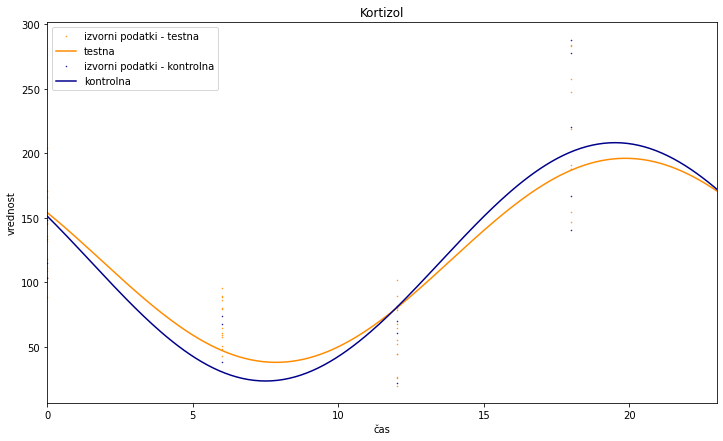

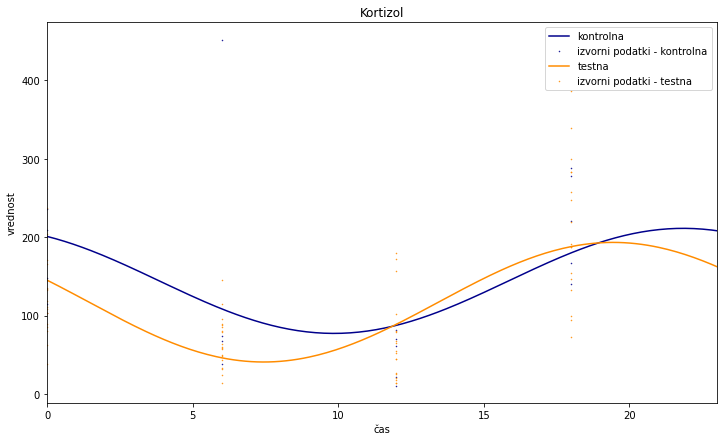

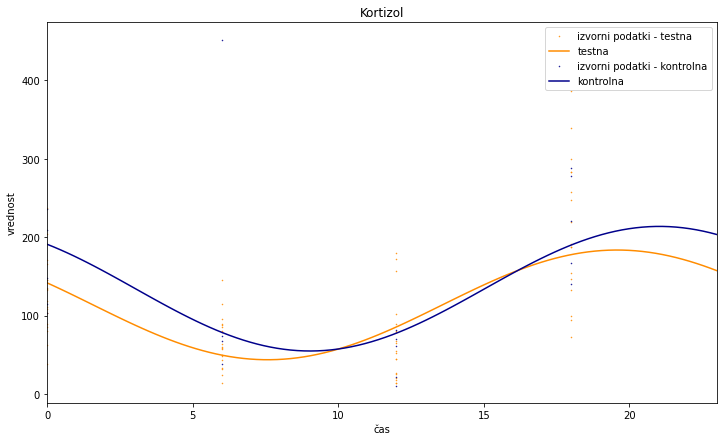

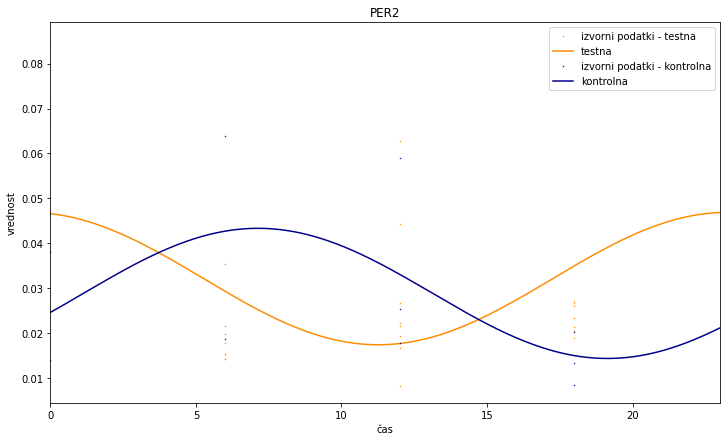

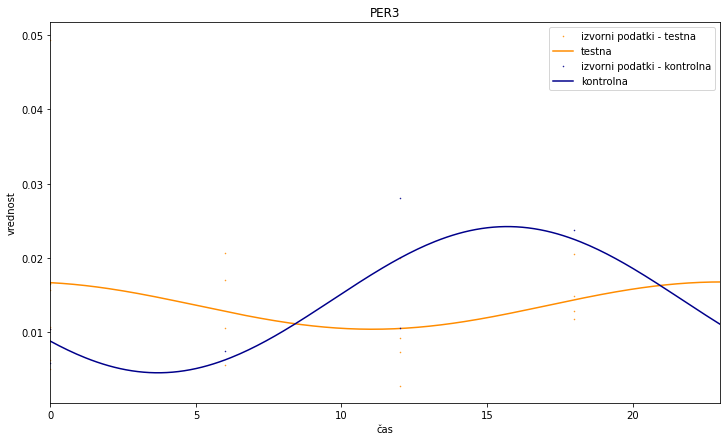

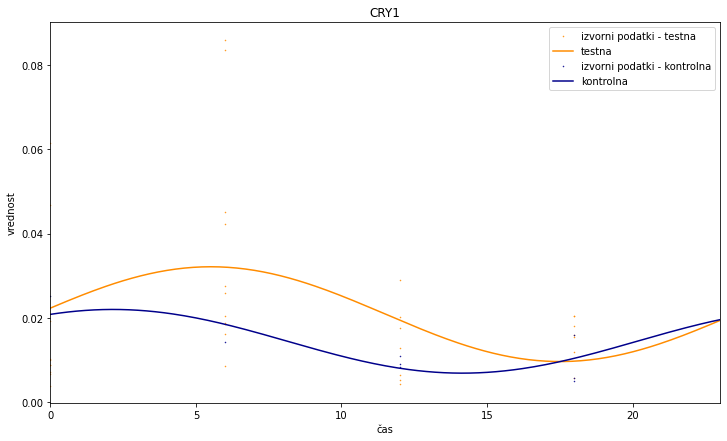

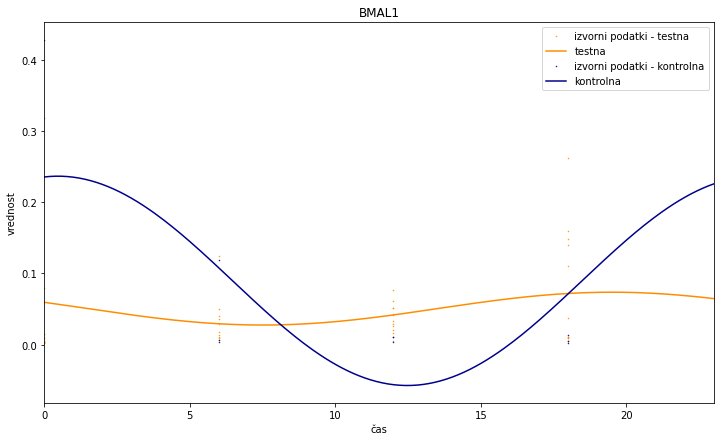

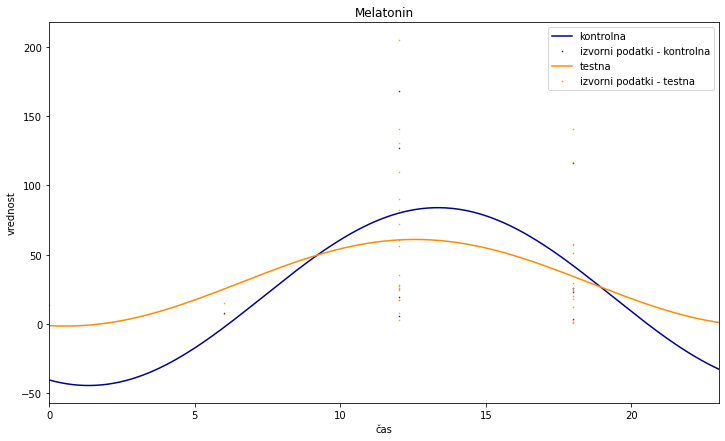

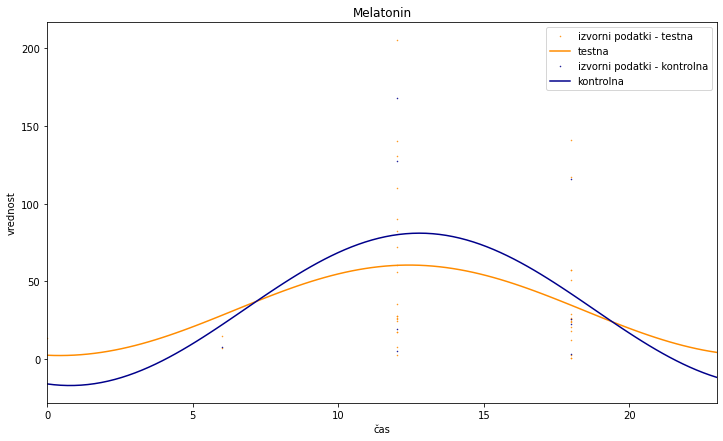

,variable,group,pop_anal,method,amplitude,acrophase,mesor
0,Kortizol,test,False,cosinor,79.12,-5.188817,116.9
1,Kortizol,control,False,cosinor,92.42,-5.110198,115.73
2,Kortizol,control,True,cosinor,67.02,-5.71294,144.21
3,Kortizol,test,True,cosinor,76.29,-5.083992,117.01
4,Kortizol,test,True,cosinor_1,69.99,-5.13,113.59
5,Kortizol,control,True,cosinor_1,79.48,-5.51,134.23
6,PER2,test,False,cosinor,0.01,-6.079826,0.03
7,PER2,control,False,cosinor,0.01,-1.860636,0.03
8,PER3,test,False,cosinor,0.0,-6.027413,0.01
9,PER3,control,False,cosinor,0.01,-4.114365,0.01


In [8]:
factors=['Kortizol','PER1','PER2','PER3','CRY1','CRY2','BMAL1','Melatonin']
methods=['cosinor']
amp_threshold=0.05
for method in methods:
    for factor in factors:
        df_new= helpers.clean_data(df, 'Hour', factor)
        df_new['population_id']=0
        df_pop = df_new.rename(columns={"Hour": "X", factor: "Y"})
        df_pop1=df_pop[df_pop['OSA']==True]
        df_pop2 = df_pop[df_pop['OSA'] == False]

        ###################################
        #   NEODVISNA OBRAVNAVA PODATKOV #
        ##################################
        results1, amp1, acr1, statistics1= dproc.non_population_fit_cosinor1(df_pop1)
        results2, amp2, acr2, statistics2 = dproc.non_population_fit_cosinor1(df_pop2)

        p_amp1 = statistics1['p-values'][1]
        p_amp2 = statistics2['p-values'][1]

        if p_amp1 < amp_threshold or p_amp2<amp_threshold:
            fig, ax = plt.subplots(1, 1, figsize=(12, 7))
            result1,ax= dproc.fit_non_population(df_pop1, method, n_components=1, n_periods=1, ax=ax, label='testna', color='darkorange', raw_label='izvorni podatki - testna')
            result2,ax= dproc.fit_non_population(df_pop2, method, n_components=1, n_periods=1, ax=ax, label='kontrolna', color='darkblue', raw_label='izvorni podatki - kontrolna')
            ax.legend()
            plt.title(factor)
            plt.savefig('./results/preseren/nonpop_'+factor+".png")
            plt.show()
            plt.close()

            if type(result1)!=int:
                row1 = {'variable': factor, 'group': 'test', 'pop_anal': False, 'method': method,
                        'amplitude': result1['amplitude'], 'acrophase': result1['acrophase'], 'mesor': result1['mesor']}
                df_results = pd.concat([df_results, (pd.DataFrame.from_dict(row1, orient='index')).T],
                                       ignore_index=True)
            if type(result2)!=int:
                row2 = {'variable': factor, 'group': 'control', 'pop_anal': False, 'method':method,'amplitude': result2['amplitude'],
                    'acrophase': result2['acrophase'], 'mesor': result2['mesor']}
                df_results = pd.concat([df_results, (pd.DataFrame.from_dict(row2, orient='index')).T],
                                       ignore_index=True)

        ###############################################
        #   POPULACIJSKA/ODVISNA OBRAVNAVA PODATKOV   #
        ##############################################
        df_new = df.copy().dropna(subset=['Hour', factor])
        df_new['population_id'] = 0
        df_pop = df_new.rename(columns={"Hour": "X", factor: "Y"})
        df_pop1 = df_pop[df_pop['OSA'] == True]
        df_pop2 = df_pop[df_pop['OSA'] == False]
        df_cosinor1 = dproc.population_fit_cosinor1(df_pop1, 24, save_to='', alpha=0.05, plot_on=False,
                                                    plot_individuals=False,
                                                    plot_measurements=False, plot_margins=False, color="blue",
                                                    hold_on=False,
                                                    plot_residuals=False, save_folder='')

        df_cosinor2 = dproc.population_fit_cosinor1(df_pop2, 24, save_to='', alpha=0.05, plot_on=False,
                                                    plot_individuals=False,
                                                    plot_measurements=False, plot_margins=False, color="blue",
                                                    hold_on=False,
                                                    plot_residuals=False, save_folder='')
        df_cosinor1 = df_cosinor1.iloc[0]
        p_amp1 = df_cosinor1['p(amplitude)']
        df_cosinor2 = df_cosinor2.iloc[0]
        p_amp2 = df_cosinor2['p(amplitude)']

        if p_amp1 < amp_threshold or p_amp2<amp_threshold:

            ########
            #  GEE #
            ########
            if method=='cosinor':
                result_gee= gee.gee_cosinor(df_new, factor, 'Hour', 'id', variables=['OSA'], n_components=1, save_to='./results/preseren/gee_' + factor + ".png", plot_title=(factor))

                if result_gee['parameter'].iloc[0][0]==False:
                    row2 = {'variable': factor, 'group': 'control', 'pop_anal': True, 'method': method,
                            'amplitude': result_gee['amplitude'].iloc[0],
                            'acrophase': result_gee['acrophase'].iloc[0], 'mesor': result_gee['mesor'].iloc[0]}
                    df_results = pd.concat([df_results, (pd.DataFrame.from_dict(row2, orient='index')).T],
                                           ignore_index=True)
                elif result_gee['parameter'].iloc[0][0]==True:
                    row2 = {'variable': factor, 'group': 'test', 'pop_anal': True, 'method': method,
                            'amplitude': result_gee['amplitude'].iloc[0],
                            'acrophase': result_gee['acrophase'].iloc[0], 'mesor': result_gee['mesor'].iloc[0]}
                    df_results = pd.concat([df_results, (pd.DataFrame.from_dict(row2, orient='index')).T],
                                           ignore_index=True)

                if result_gee['parameter'].iloc[1][0] == False:
                    row1 = {'variable': factor, 'group': 'control', 'pop_anal': True, 'method': method,
                            'amplitude': result_gee['amplitude'].iloc[1],
                            'acrophase': result_gee['acrophase'].iloc[1], 'mesor': result_gee['mesor'].iloc[1]}
                    df_results = pd.concat([df_results, (pd.DataFrame.from_dict(row1, orient='index')).T],
                                           ignore_index=True)
                elif result_gee['parameter'].iloc[1][0] == True:
                    row1 = {'variable': factor, 'group': 'test', 'pop_anal': True, 'method': method,
                            'amplitude': result_gee['amplitude'].iloc[1],
                            'acrophase': result_gee['acrophase'].iloc[1], 'mesor': result_gee['mesor'].iloc[1]}
                    df_results = pd.concat([df_results, (pd.DataFrame.from_dict(row1, orient='index')).T],
                                           ignore_index=True)

                ##################################
                #   POVPREČENJE IND. MODELOV     #
                ##################################
                row1={'variable': factor, 'group': 'test', 'pop_anal': True, 'method': 'cosinor_1',
                            'amplitude': np.round(df_cosinor1['amplitude'],2),
                            'acrophase': np.round(df_cosinor1['acrophase'],2), 'mesor': np.round(df_cosinor1['mesor'],2)}
                row2 = {'variable': factor, 'group': 'control', 'pop_anal': True, 'method': 'cosinor_1',
                        'amplitude': np.round(df_cosinor2['amplitude'],2),
                            'acrophase': np.round(df_cosinor2['acrophase'],2), 'mesor': np.round(df_cosinor2['mesor'],2)}
                df_results = pd.concat([df_results, (pd.DataFrame.from_dict(row1, orient='index')).T],
                                       ignore_index=True)
                df_results = pd.concat([df_results, (pd.DataFrame.from_dict(row2, orient='index')).T],
                                       ignore_index=True)

                X_test = np.linspace(0, 23, 100)
                y1=df_cosinor1['Y_test']
                y2=df_cosinor2['Y_test']
                fig, ax = plt.subplots(1, 1, figsize=(12, 7))
                plotter.subplot_model(df_pop1['X'].to_numpy(), df_pop1['Y'].to_numpy(), X_test, y1, ax, plot_model=True, plot_measurements=True, plot_measurements_with_color=True, color='darkorange', fit_label='testna', raw_label='izvorni podatki - testna')
                plotter.subplot_model(df_pop2['X'].to_numpy(), df_pop2['Y'].to_numpy(), X_test, y2, ax, plot_model=True, plot_measurements=True, plot_measurements_with_color=True, color='darkblue', fit_label='kontrolna', raw_label='izvorni podatki - kontrolna')
                ax.legend()
                plt.title(factor)
                plt.savefig('./results/preseren/povpr_'+factor+".png")
                plt.show()
                plt.close()


display(df_results)